<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/ML_AI24_HT7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


# **Базовое решение и пример формирования файла под submission**


In [ ]:
import numpy as np
!wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

In [ ]:
!pip install catboost -q

In [6]:
# from catboost import CatBoostClassifier
import pandas as pd
import os
from tqdm import tqdm

INPUT_DIR = r"C:\Users\vyacheslav\Downloads\Telegram Desktop"

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [7]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [8]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

431it [00:00, 3855.45it/s]


In [ ]:
X_train = df_train.drop('isFraud', axis=1)
X_train = X_train.fillna('')
y_train = df_train['isFraud'].values

cb = CatBoostClassifier(iterations=3)
cb.fit(X_train, y_train, object_cols, )

In [ ]:
predictions = cb.predict_proba(df_test.fillna(''))

In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

In [ ]:
# Сохранение submission
sub.to_csv('submission_baseline.csv', index=False)

In [ ]:
sub

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

In [96]:
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
df_train['isFraud'].value_counts(normalize=True)

isFraud
0    0.964745
1    0.035255
Name: proportion, dtype: float64

Целевая переменная сильно не сбалансированная, но это типично для данной задачи.

In [98]:
df_train = df_train[~df_train.duplicated()]

Удалим полные дубликаты

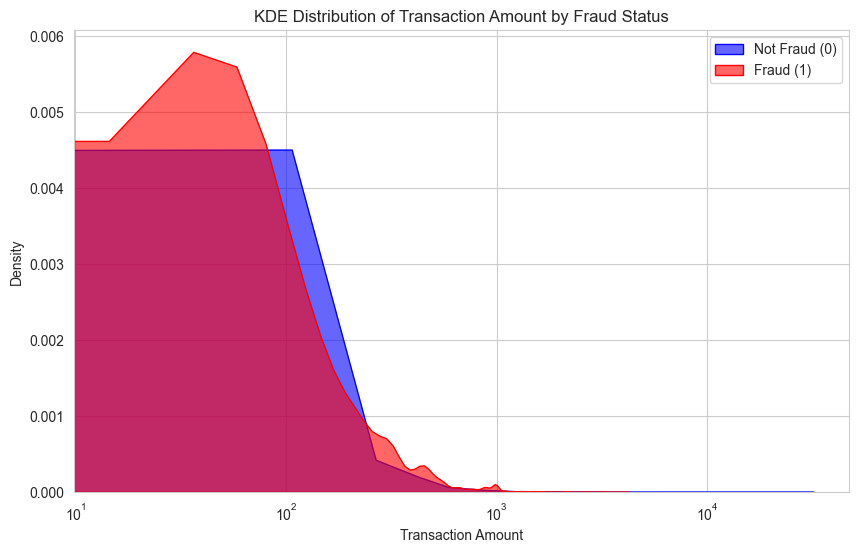

In [22]:
def plot_kde_distribution(df):
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(df[df['isFraud'] == 0]['TransactionAmt'], fill=True, color='blue', label='Not Fraud (0)', alpha=0.6)
    sns.kdeplot(df[df['isFraud'] == 1]['TransactionAmt'], fill=True, color='red', label='Fraud (1)', alpha=0.6)
    
    plt.xlabel('Transaction Amount')
    plt.xscale('log')
    plt.ylabel('Density')
    plt.title('KDE Distribution of Transaction Amount by Fraud Status')
    plt.legend()
    plt.show()


plot_kde_distribution(df_train)

Распределение транзакций сильно скошено влево (правый хвост длинный)

Основная масса значений маленькая.

Длинный правый хвост указывает на редкие крупные транзакции.
Мошеннические (isFraud = 1, красный) и немошеннические (isFraud = 0, синий) транзакции распределены похоже в малых значениях
Однако мошеннические транзакции чуть более концентрированы в малых суммах.
Это может говорить о том, что мошенники чаще оперируют небольшими суммами.

In [86]:
class FillMissingValues(BaseEstimator, TransformerMixin):    
    def __init__(self, strategy="mode"):
        if strategy not in ["mode", "median", "unknown"]:
            raise ValueError("strategy должен быть 'mode', 'median' или 'unknown'")
        self.strategy = strategy
        self.fill_values_ = None

    def fit(self, X, y=None):
        if self.strategy == "unknown":
            return self
        
        if isinstance(X, pd.DataFrame):
            if self.strategy == "mode":
                self.fill_values_ = X.mode().iloc[0]
            else:
                self.fill_values_ = X.median()
        else:
            if self.strategy == "mode":
                self.fill_values_ = pd.Series(X).mode().iloc[0]
            else:
                self.fill_values_ = pd.Series(X).median()
        return self

    def transform(self, X):
        X_filled = X.copy()

        if self.strategy == "unknown":
            return X_filled.fillna("unknown")
        
        if self.fill_values_ is None:
            raise ValueError("FillModeTransformer не обучен. Вызовите fit() перед transform().")
        
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                X_filled[col] = X_filled[col].fillna(self.fill_values_[col])
        else:
            X_filled = X.fillna(self.fill_values_)
        return X_filled
    

# transformer = FillMissingValues()
# transformer.fit(df_train[['card4']])
# transformer.transform(df_train[['card4']])
# transformer.transform(df_test[['card4']])

In [79]:
def extract_os(os_string):
    if pd.isna(os_string):
        return os_string
    os_string = os_string.lower()
    if "windows" in os_string:
        return "Windows"
    elif "mac os" in os_string or "mac" in os_string:
        return "MacOS"
    elif "ios" in os_string:
        return "iOS"
    elif "android" in os_string:
        return "Android"
    elif "linux" in os_string:
        return "Linux"
    else:
        return "Other"

df_train["id_30"] = df_train["id_30"].apply(extract_os)

Выдернем у группы id_30 информацию основную об устройстве.

Заметим, что у нас присутствует большое кол-во пропусков в категориальных признаках. Предлагаю исправлять у таких признаков, как 'DeviceInfo', 'id_31', 'id_33', 'P_emaildomain', 'R_emaildomain' больше кол-во отсутствующих значений у категориальных признаков с помощью объединения в более крупные группы и присвоения особой группы для всех отсутствующих значений, а дальше закодировать с помощью счетчиков (если нужно для алгоритма).
В card4 и card6 заполним пропуски просто модой.
Остальные категориальные переменные предлагаю оставить, просто создав новую категорию, обозначающую отсутствующее значение.
 

In [87]:
class TopNCategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10):
        self.top_n = top_n
        self.top_categories_ = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0]
        self.top_categories_ = set(X.value_counts().index[:self.top_n].values)
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0]

        def categorize(value):
            if pd.isna(value):
                return "unknown"
            elif value in self.top_categories_:
                return value
            else:
                return "other"

        return X.apply(categorize).to_frame()


In [55]:
df_train.select_dtypes(include=['number']).describe()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,417559.000000,417559.000000,417559.000000,410996.000000,416738.000000,414578.000000,369586.000000,369586.000000,159468.000000,29286.000000,...,107259.000000,34269.000000,107226.000000,107209.000000,3950.000000,3954.000000,3624.000000,3930.000000,3948.000000,62116.000000
mean,0.035255,134.666566,9865.320371,363.474253,153.347864,199.687439,290.437990,86.762670,124.795796,239.833094,...,187.936416,14.172547,352.299619,400.498661,371.863038,15.991148,12.790563,328.534351,148.645643,26.635327
std,0.184424,238.166118,4900.674210,158.146603,11.566162,40.783018,101.852266,2.930881,381.805459,538.292779,...,30.118252,1.479054,140.265671,150.423924,200.186906,6.891239,2.189355,98.821070,32.355822,3.787343
min,0.000000,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,0.000000,42.950000,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,3.000000,7.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,0.000000,68.950000,9633.000000,361.000000,150.000000,226.000000,299.000000,87.000000,9.000000,36.000000,...,166.000000,15.000000,341.000000,469.000000,252.000000,14.000000,11.000000,321.000000,147.000000,24.000000
75%,0.000000,125.000000,14128.000000,512.000000,150.000000,226.000000,330.000000,87.000000,25.000000,225.000000,...,225.000000,15.000000,427.000000,521.000000,500.000000,14.000000,15.000000,371.000000,169.000000,32.000000
max,1.000000,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,10286.000000,11623.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


У фичей id_21 id_22 id_24 id_25 id_26 очень мало значений около 4 т. и небольшая корреляция с ЦП, возможно их стоило бы совсем исключить, но мы заполним их медианой.
Заполним остальные числовые признаки медианами, также отметим, что во многих из них встречаются выбросы.

In [56]:
df_train.select_dtypes(include=['number']).corr()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
isFraud,1.000000,0.009483,-0.014045,0.001770,0.147305,-0.037140,-0.002122,-0.033326,0.021164,-0.018474,...,0.150022,0.055578,-0.032266,0.061558,0.045967,0.105125,-0.072429,0.037179,0.073745,0.066338
TransactionAmt,0.009483,1.000000,-0.001607,0.015450,-0.111239,0.001733,-0.007828,0.032196,0.026503,0.020575,...,-0.317657,-0.085228,0.071836,-0.104391,-0.024534,-0.105445,0.062199,0.031998,0.022434,-0.053061
card1,-0.014045,-0.001607,1.000000,0.002618,-0.000444,-0.087744,0.018365,-0.000944,0.008260,0.000346,...,0.019009,0.000722,0.007894,0.007106,0.043930,0.012329,0.051554,0.005820,0.085630,0.003826
card2,0.001770,0.015450,0.002618,1.000000,0.025930,0.031181,0.029185,-0.024645,-0.011497,0.017956,...,-0.029116,-0.016906,0.003641,-0.010966,-0.015174,-0.031990,-0.008905,-0.026556,-0.000548,-0.029126
card3,0.147305,-0.111239,-0.000444,0.025930,1.000000,-0.165335,0.004521,-0.574966,-0.011144,-0.146727,...,0.747677,0.182891,-0.156859,0.252282,0.098004,0.648576,-0.002258,0.150045,0.238839,0.006112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_22,0.105125,-0.105445,0.012329,-0.031990,0.648576,-0.169167,0.084520,-0.351236,NaN,0.052436,...,0.552212,0.097398,0.054881,0.041760,0.066247,1.000000,-0.024287,0.199228,0.285176,-0.070921
id_24,-0.072429,0.062199,0.051554,-0.008905,-0.002258,0.000444,-0.038008,-0.043411,NaN,0.046945,...,-0.026859,0.042252,0.298442,-0.215523,0.263598,-0.024287,1.000000,-0.041787,0.092900,-0.293483
id_25,0.037179,0.031998,0.005820,-0.026556,0.150045,-0.066636,0.002416,0.009848,NaN,-0.046301,...,0.156206,0.136108,-0.009851,-0.032913,-0.141083,0.199228,-0.041787,1.000000,0.034601,0.049785
id_26,0.073745,0.022434,0.085630,-0.000548,0.238839,-0.090610,0.042504,-0.070406,NaN,0.158301,...,0.066922,-0.087288,0.164866,0.026037,0.068954,0.285176,0.092900,0.034601,1.000000,-0.067784


Как мы видим наибольшая корреляция Пирсона у ЦП и признаков:
V257
V244
V242
V246
V201
Однако, они анонимные и выводы сделать сложно.

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

In [95]:
Top_categorical_pipeline = Pipeline([
    ("email_encoder", TopNCategoricalEncoder(top_n=10)),
    ("target_encoder", FillMissingValues())
])


Target_encoding_pipeline = Pipeline([
    ("fill_missing", FillMissingValues(strategy="unknown")),
    ("target_encoder", TargetEncoder(smoothing=0.3))
])

categorical_processing = FeatureUnion([
    ("original_encoding", ColumnTransformer(
        transformers=[
            ("cat_transf1", FillMissingValues(strategy='mode'), ['card4', 'card6']),
            ("cat_transf2", Top_categorical_pipeline, ['DeviceInfo', 'id_30', 'id_31', 'id_33', 'P_emaildomain', 'R_emaildomain']),
            ("cat_transf3", FillMissingValues(strategy='unknown'), ['ProductCD', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                                                                   'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29',
                                                                   'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType'])
        ]
    )),
    ("target_encoding", Target_encoding_pipeline)
])

full_pipeline = ColumnTransformer(
    transformers=[
        ("cat_transf", categorical_processing, ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
                                                'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
                                                'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
                                                'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']),
        ("num_transf", FillMissingValues(strategy='median'), df_train.select_dtypes(include=['number']).columns)
    ]
)



full_pipeline.fit(df_train)

full_pipeline.transform(df_train)

array([['discover', 'credit', 'unknown', ..., 321.0, 147.0, 24.0],
       ['mastercard', 'credit', 'unknown', ..., 321.0, 147.0, 24.0],
       ['visa', 'debit', 'unknown', ..., 321.0, 147.0, 24.0],
       ...,
       ['visa', 'debit', 'other', ..., 321.0, 147.0, 24.0],
       ['visa', 'debit', 'unknown', ..., 321.0, 147.0, 24.0],
       ['visa', 'debit', 'unknown', ..., 321.0, 147.0, 24.0]],
      dtype=object)

In [84]:
df_train.select_dtypes(exclude=['number']).columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# ваша работа с аномалиями здесь

# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# ваши эксперименты с кластеризацией здесь

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [ ]:
# ваш AutoML здесь

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

In [ ]:
# ваши эксперименты здесь

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

In [ ]:
# не забудьте прикрепить скриншоты лидерборда, пожалуйста